In [1]:
import psycopg2
import pandas as pd
import numpy as np
import seaborn as sns
import scipy
import matplotlib.pyplot as plt

In [2]:
conn = psycopg2.connect('dbname=soccer')
cur = conn.cursor()

query = '''
SELECT *
FROM Country
;'''

cur.execute(query)

In [3]:
countries_data = cur.fetchall()
countries_df = pd.DataFrame(countries_data)
countries_df.columns = [i[0] for i in cur.description]
countries_df.head()

,id,name
0,1,Belgium
1,1729,England
2,4769,France
3,7809,Germany
4,10257,Italy


In [4]:
#Is there a statistical difference in the odds of 
#winning a game when a team is playing in front of their home crowd?

In [5]:
#type of test?
#likelihood of random noise?
#how confident are we?

In [6]:
conn = psycopg2.connect('dbname=soccer')
cur = conn.cursor()

query = '''
SELECT *
FROM League
;'''

cur.execute(query)

league_data = cur.fetchall()
league_df = pd.DataFrame(league_data)
league_df.columns = [i[0] for i in cur.description]
league_df.head()

,id,country_id,name
0,1,1,Belgium Jupiler League
1,1729,1729,England Premier League
2,4769,4769,France Ligue 1
3,7809,7809,Germany 1. Bundesliga
4,10257,10257,Italy Serie A


In [7]:
conn = psycopg2.connect('dbname=soccer')
cur = conn.cursor()

query = '''
SELECT *
FROM Match
;'''

cur.execute(query)

match_data = cur.fetchall()
match_df = pd.DataFrame(match_data)
match_df.columns = [i[0] for i in cur.description]

In [8]:
match_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25979 entries, 0 to 25978
Columns: 115 entries, id to bsa
dtypes: float64(66), int64(9), object(40)
memory usage: 22.8+ MB


In [9]:
conn = psycopg2.connect('dbname=soccer')
cur = conn.cursor()

query = '''
SELECT *
FROM Player_Attributes
;'''

cur.execute(query)

player_attrib_data = cur.fetchall()
player_attrib_df = pd.DataFrame(player_attrib_data)
player_attrib_df.columns = [i[0] for i in cur.description]
player_attrib_df.head()

,id,player_fifa_api_id,player_api_id,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
0,1,218353,505942,2016-02-18 00:00:00,67.0,71.0,right,medium,medium,49.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
1,2,218353,505942,2015-11-19 00:00:00,67.0,71.0,right,medium,medium,49.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
2,3,218353,505942,2015-09-21 00:00:00,62.0,66.0,right,medium,medium,49.0,...,54.0,48.0,65.0,66.0,69.0,6.0,11.0,10.0,8.0,8.0
3,4,218353,505942,2015-03-20 00:00:00,61.0,65.0,right,medium,medium,48.0,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0
4,5,218353,505942,2007-02-22 00:00:00,61.0,65.0,right,medium,medium,48.0,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0


In [10]:
conn = psycopg2.connect('dbname=soccer')
cur = conn.cursor()

query = '''
SELECT *
FROM Team
;'''

cur.execute(query)

team_data = cur.fetchall()
team_df = pd.DataFrame(team_data)
team_df.columns = [i[0] for i in cur.description]
team_df.head()

,id,team_api_id,team_fifa_api_id,team_long_name,team_short_name
0,1,9987,673.0,KRC Genk,GEN
1,2,9993,675.0,Beerschot AC,BAC
2,3,10000,15005.0,SV Zulte-Waregem,ZUL
3,4,9994,2007.0,Sporting Lokeren,LOK
4,5,9984,1750.0,KSV Cercle Brugge,CEB


In [11]:
conn = psycopg2.connect('dbname=soccer')
cur = conn.cursor()

query = '''
SELECT *
FROM Team_Attributes
;'''

cur.execute(query)

team_attrib_data = cur.fetchall()
team_attrib_df = pd.DataFrame(team_attrib_data)
team_attrib_df.columns = [i[0] for i in cur.description]
team_attrib_df.head()

,id,team_fifa_api_id,team_api_id,date,buildupplayspeed,buildupplayspeedclass,buildupplaydribbling,buildupplaydribblingclass,buildupplaypassing,buildupplaypassingclass,...,chancecreationshooting,chancecreationshootingclass,chancecreationpositioningclass,defencepressure,defencepressureclass,defenceaggression,defenceaggressionclass,defenceteamwidth,defenceteamwidthclass,defencedefenderlineclass
0,1,434,9930,2010-02-22 00:00:00,60,Balanced,NaN,Little,50,Mixed,...,55,Normal,Organised,50,Medium,55,Press,45,Normal,Cover
1,2,434,9930,2014-09-19 00:00:00,52,Balanced,48.0,Normal,56,Mixed,...,64,Normal,Organised,47,Medium,44,Press,54,Normal,Cover
2,3,434,9930,2015-09-10 00:00:00,47,Balanced,41.0,Normal,54,Mixed,...,64,Normal,Organised,47,Medium,44,Press,54,Normal,Cover
3,4,77,8485,2010-02-22 00:00:00,70,Fast,NaN,Little,70,Long,...,70,Lots,Organised,60,Medium,70,Double,70,Wide,Cover
4,5,77,8485,2011-02-22 00:00:00,47,Balanced,NaN,Little,52,Mixed,...,52,Normal,Organised,47,Medium,47,Press,52,Normal,Cover


In [12]:
player_df = pd.read_csv('player.csv')
player_df.head()

,id,player_api_id,player_name,player_fifa_api_id,birthday,height,weight
0,1,505942,Aaron Appindangoye,218353,1992-02-29 00:00:00,182.88,187
1,2,155782,Aaron Cresswell,189615,1989-12-15 00:00:00,170.18,146
2,3,162549,Aaron Doran,186170,1991-05-13 00:00:00,170.18,163
3,4,30572,Aaron Galindo,140161,1982-05-08 00:00:00,182.88,198
4,5,23780,Aaron Hughes,17725,1979-11-08 00:00:00,182.88,154


### HYPOTHESIS TEST 1:
##### Is there a statistical difference in the odds of winning a game when a team is playing in front of their home crowd?

- H0 (Null Hypothesis): there is no statistical difference in the odds of winning a game when a team is at playing at home
- HA (Alternative Hypothesis): there is a statistical difference in the odds of winning a game when a team is playing at home 

- Alpha = 0.05

##### Assumptions:
- Data is collected randomly
- Data is independent
- Data is approximately normally distributed

In [13]:
#create new column home_team_win with binary values - Home team winning = 1, Tie=0.5, Away team winning = 0
match_df['home_team_win'] = np.zeros

match_df['home_team_win'].loc[match_df['home_team_goal'] > match_df['away_team_goal']] = 1
match_df['home_team_win'].loc[match_df['home_team_goal'] < match_df['away_team_goal']] = 0
match_df['home_team_win'].loc[match_df['home_team_goal'] == match_df['away_team_goal']] = 0

/Applications/anaconda3/envs/learn-env/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [14]:
match_dff = match_df.dropna()

In [15]:
home_team_win_array = np.array(match_dff['home_team_win'])

sample_means = []
for _ in range(1000):
    sample_mean = np.random.choice(home_team_win_array, size=1000).mean()
    sample_means.append(sample_mean)

In [16]:
np.mean(home_team_win_array)

0.4557321225879682

In [17]:


mu = np.mean(home_team_win_array)
x_bar = np.mean(sample_means)
sigma = np.std(sample_means,ddof=1)
n = len(sample_means)
df = n-1
diff = x_bar - mu

print(mu, x_bar, sigma, n, df, diff)

0.4557321225879682 0.456179 0.016115106442579137 1000 999 0.00044687741203180975


/Applications/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


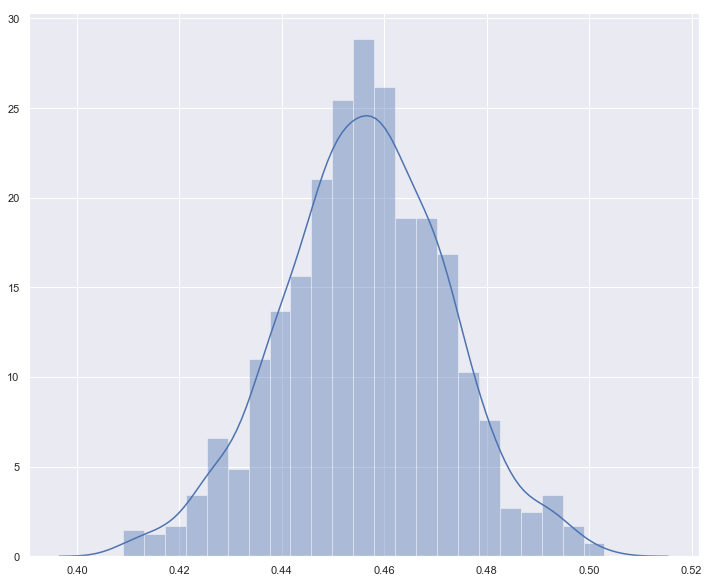

In [18]:
#plot the sample dist
sns.set(color_codes=True)
sns.set(rc={'figure.figsize':(12,10)})

sns.distplot(sample_means)

In [19]:
t = (x_bar - mu) / (sigma/(np.sqrt(n)))
t

0.8769104082168785

In [20]:
alpha=0.05

t_crit = scipy.stats.t.ppf(1-alpha, df)
t_crit

1.646380345427535

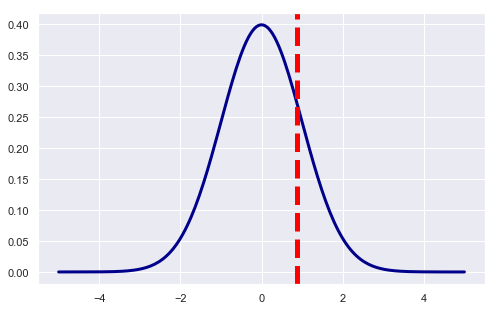

In [21]:
# generate points on the x axis between -5 and 5:
xs = np.linspace(-5, 5, 200)
# use stats.t.pdf to get values on the probability density function for the t-distribution
# the second argument is the degrees of freedom
ys = scipy.stats.t.pdf(xs,df,0,1)
# initialize a matplotlib "figure"
fig = plt.figure(figsize=(8,5))

# get the current "axis" out of the figure
ax = fig.gca()

# plot the lines using matplotlib's plot function:
ax.plot(xs, ys, linewidth=3, color='darkblue')

# plot a vertical line for our measured difference in rates t-statistic
ax.axvline(t, color='red', linestyle='--', lw=5)
plt.show()

## Conclusion:
### We fail to reject the null hypothesis and with 95% confidence state that there is no statistical difference in the odds of winning a game when a team is at playing at home

 ## HYPOTHESIS TEST 3


- There is no statisical difference in the defensive agressiveness between English and Spanish Teams
 
- HA: There is a difference in the defensive aggresiveness between English and Spanish Teams.

### Merging 

In [22]:
match_league_df = match_df.merge(league_df, left_on='league_id', right_on='id')

In [23]:
match_league_df['name'].value_counts()

Spain LIGA BBVA             3040
France Ligue 1              3040
England Premier League      3040
Italy Serie A               3017
Germany 1. Bundesliga       2448
Netherlands Eredivisie      2448
Portugal Liga ZON Sagres    2052
Poland Ekstraklasa          1920
Scotland Premier League     1824
Belgium Jupiler League      1728
Switzerland Super League    1422
Name: name, dtype: int64

In [24]:
match_league_team_df = match_df.merge(team_df, left_on='home_team_api_id', right_on='team_api_id')

In [25]:
team_attrib_by_league = team_attrib_df.merge(match_league_df, left_on='team_api_id', right_on='home_team_api_id')

In [26]:
team_attrib_by_league_home = team_attrib_df.merge(match_league_df, left_on='team_api_id', right_on='home_team_api_id')
team_attrib_by_league_away = team_attrib_df.merge(match_league_df, left_on='team_api_id', right_on='away_team_api_id')


In [27]:
team_attrib_by_league_home.T.head()

,0,1,2,3,4,5,6,7,8,9,...,142083,142084,142085,142086,142087,142088,142089,142090,142091,142092
id,1,1,1,1,1,1,1,1,1,1,...,1458,1458,1458,1458,1458,1458,1458,1458,1458,1458
team_fifa_api_id,434,434,434,434,434,434,434,434,434,434,...,15005,15005,15005,15005,15005,15005,15005,15005,15005,15005
team_api_id,9930,9930,9930,9930,9930,9930,9930,9930,9930,9930,...,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000
date_x,2010-02-22 00:00:00,2010-02-22 00:00:00,2010-02-22 00:00:00,2010-02-22 00:00:00,2010-02-22 00:00:00,2010-02-22 00:00:00,2010-02-22 00:00:00,2010-02-22 00:00:00,2010-02-22 00:00:00,2010-02-22 00:00:00,...,2015-09-10 00:00:00,2015-09-10 00:00:00,2015-09-10 00:00:00,2015-09-10 00:00:00,2015-09-10 00:00:00,2015-09-10 00:00:00,2015-09-10 00:00:00,2015-09-10 00:00:00,2015-09-10 00:00:00,2015-09-10 00:00:00
buildupplayspeed,60,60,60,60,60,60,60,60,60,60,...,54,54,54,54,54,54,54,54,54,54


In [30]:
defense = team_attrib_by_league_home[['defenceaggression', 'team_api_id', 'name']]
defense.head()

,defenceaggression,team_api_id,name
0,55,9930,Switzerland Super League
1,55,9930,Switzerland Super League
2,55,9930,Switzerland Super League
3,55,9930,Switzerland Super League
4,55,9930,Switzerland Super League


### We need to slice our dataframes in order to only have information about certain leagues:

In [59]:
#swiss_d = defense.loc[defense['defenseaggression'], 'name' == 'Switzerland Super League']
swiss_d = defense[defense['name'].str.contains("Switzerland")==True]
belgium_d = defense[defense['name'].str.contains("Belgium")==True]
english_d = defense[defense['name'].str.contains("England")==True]
spanish_d = defense[defense['name'].str.contains("Spain")==True]


#### Create Numpy Arrays of Match/Defense Aggressiveness Data

In [62]:
swiss_array_df = swiss_d['defenceaggression']
swiss_array = np.array(swiss_array_df)
swiss_array # This is an array of all of the defensive aggressiveness scores per match in the swiss league 

array([55, 55, 55, ..., 34, 34, 34])

In [63]:
belgium_array_df = belgium_d['defenceaggression']
belgium_array = np.array(belgium_array_df)
belgium_array # This is an array of all of the defensive aggressiveness scores per match in the belgium league 

array([50, 50, 50, ..., 58, 58, 58])

In [64]:
english_array_df = english_d['defenceaggression']
english_array = np.array(english_array_df)
english_array

array([40, 40, 40, ..., 48, 48, 48])

In [65]:
spanish_array_df = spanish_d['defenceaggression']
spanish_array = np.array(spanish_array_df)
spanish_array

array([65, 65, 65, ..., 43, 43, 43])

In [66]:
home_means = team_attrib_by_league_home.groupby('name').mean()
away_ = team_attrib_by_league_away.groupby('name').mean()

## Swiss vs Belgium Defensive Agressiveness

/Applications/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


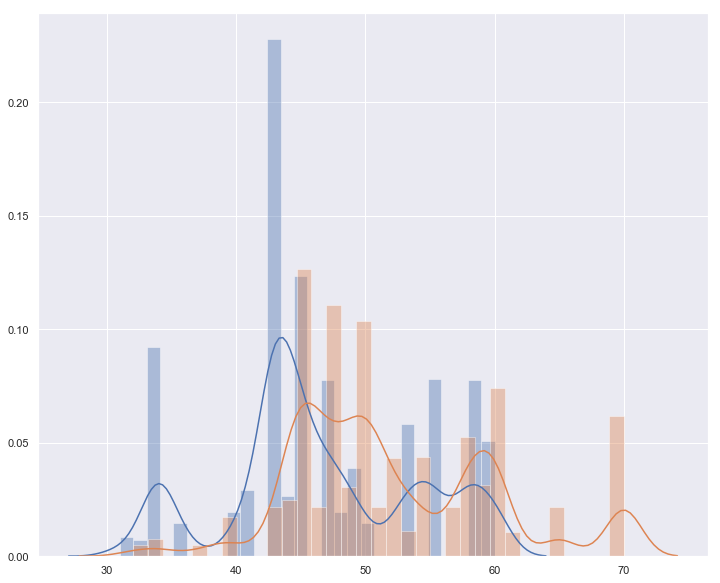

In [38]:
sns.set(color_codes=True)
sns.set(rc={'figure.figsize':(12,10)})
sns.distplot(swiss_array) # Blue distribution
sns.distplot(belgium_array) # Green distribution

In [39]:
a = swiss_array.mean()

In [40]:
b = belgium_array.mean()

In [41]:
diff_means = a-b
diff_means

-5.629120869433102

In [43]:
sample_means_swiss = []
for _ in range(50):
    sample_mean = np.random.choice(swiss_array,size=50).mean()
    sample_means_swiss.append(sample_mean)
len(sample_means_swiss)

sample_means_belgium = []
for _ in range(50):
    sample_mean = np.random.choice(belgium_array,size=50).mean()
    sample_means_belgium.append(sample_mean)
len(sample_means_belgium)

50

In [57]:
#sample_means_swiss

In [56]:
#sample_means_belgium

In [47]:
def variance(sample):
    sample_mean = np.mean(sample)
    return sum([(i - sample_mean)**2 for i in sample])

In [48]:
def sample_variance(sample1, sample2):
    n_1, n_2 = len(sample1), len(sample2)
    var_1, var_2 = variance(sample1), variance(sample2)
    return (var_1 + var_2)/((n_1 + n_2)-2)

In [49]:
def variance(sample):
    sample_mean = np.mean(sample)
    return sum([(i - sample_mean)**2 for i in sample])

def sample_variance(sample1, sample2):
    n_1, n_2 = len(sample1), len(sample2)
    var1, var2 = variance(sample1), variance(sample2)
    return (var1 + var2) / ((n_1 + n_2) - 2)

def twosample_tstatistic(expr, ctrl):
    expr_mean, ctrl_mean = np.mean(expr), np.mean(ctrl)
    n_e, n_c = len(expr), len(ctrl)
    samp_var = sample_variance(expr,ctrl)
    t = (expr_mean - ctrl_mean) / np.sqrt(samp_var * ((1/n_e)+(1/n_c)))
    return t

t_stat = twosample_tstatistic(sample_means_swiss, sample_means_belgium)

t_stat

-28.735745031421086

In [50]:
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt


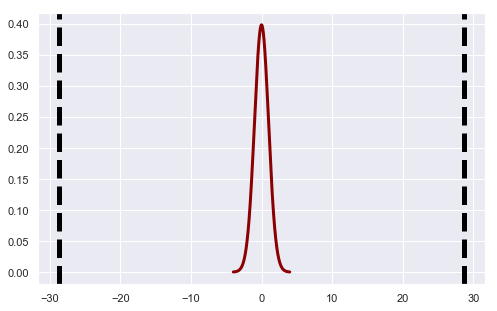

In [52]:
def visualize_t(t_stat, n_control, n_experimental):

    # initialize a matplotlib "figure"
    fig = plt.figure(figsize=(8,5))
    ax = fig.gca()
    # generate points on the x axis between -4 and 4:
    xs = np.linspace(-4, 4, 500)

    # use stats.t.pdf to get values on the probability density function for the t-distribution
    
    ys= stats.t.pdf(xs, (n_control+n_experimental-2), 0, 1)
    ax.plot(xs, ys, linewidth=3, color='darkred')

    ax.axvline(t_stat, color='black', linestyle='--', lw=5)
    ax.axvline(-t_stat, color='black', linestyle='--', lw=5)

    plt.show()
    return None

n_control = len(sample_means_swiss)
n_experimental = len(sample_means_belgium)
visualize_t(t_stat, n_control, n_experimental)

In [55]:
stats.ttest_ind(sample_means_swiss, sample_means_belgium)

Ttest_indResult(statistic=-28.735745031421086, pvalue=1.5386087853000813e-49)

## England Vs Spain Defensive Aggressiveness

/Applications/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


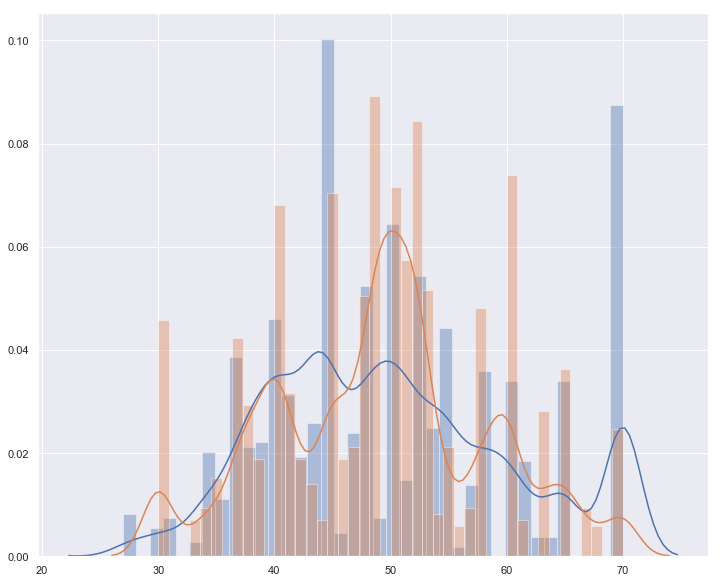

In [71]:
sns.set(color_codes=True)
sns.set(rc={'figure.figsize':(12,10)})
sns.distplot(english_array) # Blue distribution
sns.distplot(spanish_array) # Green distribution

In [72]:
sample_means_english = []
for _ in range(50):
    sample_mean = np.random.choice(english_array,size=50).mean()
    sample_means_english.append(sample_mean)
len(sample_means_english)

sample_means_spanish = []
for _ in range(50):
    sample_mean = np.random.choice(spanish_array,size=50).mean()
    sample_means_spanish.append(sample_mean)
len(sample_means_spanish)

50

In [74]:
sample_means_english
sample_means_spanish

[49.0,
 48.94,
 50.62,
 48.54,
 45.02,
 50.42,
 48.62,
 49.14,
 48.64,
 50.16,
 48.3,
 51.8,
 47.86,
 50.52,
 48.72,
 49.1,
 49.58,
 48.4,
 50.18,
 48.86,
 50.02,
 46.7,
 50.66,
 49.76,
 48.54,
 49.84,
 49.62,
 48.1,
 48.18,
 49.76,
 50.54,
 45.66,
 51.26,
 48.6,
 48.8,
 48.52,
 48.94,
 49.08,
 48.08,
 50.64,
 49.0,
 48.68,
 49.32,
 51.16,
 51.12,
 48.0,
 50.18,
 49.66,
 48.42,
 48.9]

In [75]:
t_stat = twosample_tstatistic(sample_means_english, sample_means_spanish)

t_stat

2.5188908490358557

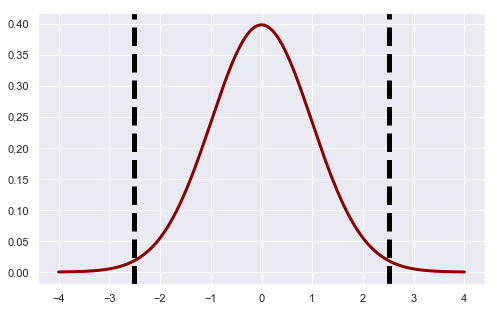

In [76]:
def visualize_t(t_stat, n_control, n_experimental):

    # initialize a matplotlib "figure"
    fig = plt.figure(figsize=(8,5))
    ax = fig.gca()
    # generate points on the x axis between -4 and 4:
    xs = np.linspace(-4, 4, 500)

    # use stats.t.pdf to get values on the probability density function for the t-distribution
    
    ys= stats.t.pdf(xs, (n_control+n_experimental-2), 0, 1)
    ax.plot(xs, ys, linewidth=3, color='darkred')

    ax.axvline(t_stat, color='black', linestyle='--', lw=5)
    ax.axvline(-t_stat, color='black', linestyle='--', lw=5)

    plt.show()
    return None

n_control = len(sample_means_english)
n_experimental = len(sample_means_spanish)
visualize_t(t_stat, n_control, n_experimental)

In [77]:
stats.ttest_ind(sample_means_english, sample_means_spanish)

Ttest_indResult(statistic=2.5188908490358553, pvalue=0.013390650158095783)